In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
import dask.dataframe as dd
import dask

# Import our utility functions
sys.path.append('..')
from notebooks.file_structure_utils import (
    analyze_plate_structure,
    get_image_path,
    get_available_channels,
    extract_cell_from_site,
    create_rgb_cell_image
)

data_dir = '../../njwfish/DistributionEmbeddings/data/ops'

In [2]:
plate_structure = analyze_plate_structure(base_dir=data_dir, screen='screenA')
plate_structure

,plate,channel_dir,channel_patterns
0,20200206_6W-LaC025B,DAPI-GFP-A594-AF750,"AF750, DAPI-GFP, A594"
1,20200202_6W-LaC024C,A594-AF750,"A594, AF750"
2,20200206_6W-LaC025A,DAPI-GFP-A594-AF750,"A594, DAPI-GFP"
3,20200202_6W-LaC024D,DAPI-GFP-A594-AF750,"AF750, A594"
4,20200202_6W-LaC024F,DAPI-GFP-A594-AF750,"AF750, DAPI-GFP"
5,20200202_6W-LaC024A,DAPI-GFP-A594-AF750,"AF750, DAPI-GFP"
6,20200202_6W-LaC024E,DAPI-GFP-A594-AF750,"AF750, DAPI-GFP"
7,20200202_6W-LaC024B,A594-AF750,"A594, AF750"


In [2]:
# Load the metadata
df = dd.read_parquet(data_dir+'/interphase-reclassified_cp_phenotype_normalized.parquet', engine='pyarrow')

# Convert to pandas DataFrame (small sample)
df_sample = df.head(10000)
print(f"Sample data shape: {df_sample.shape}")

Sample data shape: (1994, 1131)


/orcd/home/002/gokulg/miniforge3/envs/distemb/lib/python3.11/site-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 1994 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


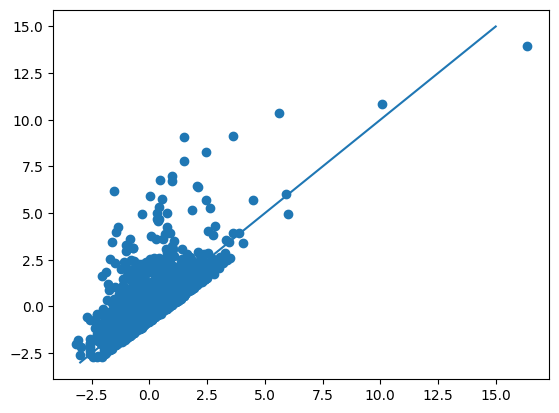

In [22]:
plt.scatter(df_sample['cell_first_neighbor_distance'],
            df_sample['cell_second_neighbor_distance'])
plt.plot([-3, 15], [-3, 15])


In [5]:
# Test the image path construction function on a sample row
if len(df_sample) > 0:
    sample_row = df_sample.iloc[0]
    plate = sample_row['plate']
    well = sample_row['well']
    site = sample_row['site']
    
    print(f"Sample cell - Plate: {plate}, Well: {well}, Site: {site}")
    
    # Try constructing paths for different channels
    for channel in ['DAPI-GFP']:
        path = get_image_path(plate, well, site, channel, base_dir=data_dir)
        exists = path is not None and os.path.exists(path)
        print(f"Channel: {channel}, Path: {path}")
        print(f"File exists: {exists}\n")

Sample cell - Plate: 20200202_6W-LaC024A, Well: A1, Site: 63
Channel: DAPI-GFP, Path: ../../njwfish/DistributionEmbeddings/data/ops/screenA/20200202_6W-LaC024A/phenotype/images/input/DAPI-GFP-A594-AF750/20X_DAPI-GFP-A594-AF750_A1_DAPI-GFP_Site-63.tif
File exists: True



In [11]:
s = df_sample.iloc[0:1]
s

,plate,tile,well,label,cell_0,i_0,j_0,site,cell_1,i_1,...,nucleus_number_neighbors_1,nucleus_percent_touching_1,nucleus_first_neighbor_distance,nucleus_second_neighbor_distance,nucleus_angle_between_neighbors,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors
sgRNA_0,,,,,,,,,,,,,,,,,,,,,
AAAACAAAAGCAGATGACCG,20200202_6W-LaC024A,211,A1,546,546,1310.869717,2728.467429,63,2120,696.294574,...,0.0,0.0,-1.22194,0.702316,-0.929039,0.0,0.229177,-0.804786,1.014519,-1.209646


590
Found cell with available channels: ['DAPI-GFP', 'A594', 'AF750']
Plate: 20200202_6W-LaC024A, Well: A1, Site: 211
Channel DAPI-GFP image shape: (4, 2, 2960, 2960)
Channel A594 image shape: (2960, 2960, 4)
Channel AF750 image shape: (2960, 2960, 4)
Cell images: [(2960, 2960, 4), (2960, 2960, 4), (2960, 2960, 4), (2960, 2960, 4)]


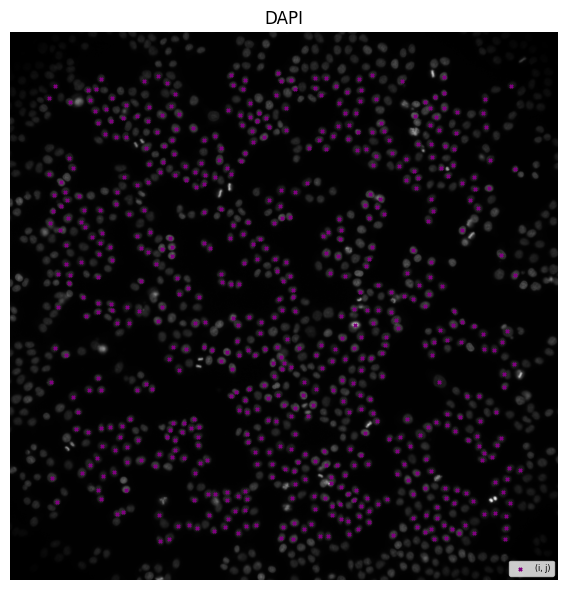

In [24]:
for i, (_, row) in enumerate(s.iterrows()):
    plate = row['plate']
    well = row['well']
    site = row['tile']

    just_here = df[(df['plate'] == plate) 
              & (df['well'] == well) & (df['tile'] == site)]
    
    print(len(just_here))

    # Check if channels are available
    available_channels = get_available_channels(plate, well, site, base_dir=data_dir)

    if available_channels:
        print(f"Found cell with available channels: {available_channels}")
        print(f"Plate: {plate}, Well: {well}, Site: {site}")
        
        cell_bounds = [0,0, 2960, 2960]

        cell_images = extract_cell_from_site(plate, well, site, cell_bounds, pad=0, base_dir=data_dir, screen='screenA')
        print(f"Cell images: {[cell_images.shape for cell_images in cell_images.values()]}")
        # transform row['cell_i'] row['cell_j'] to the image coordinates
        
        cell_images = {'DAPI' : cell_images['DAPI']}

        fig, axes = plt.subplots(1, len(cell_images), figsize=(6, 6))
        
        if len(cell_images) == 1:
            axes = [axes]
        
        c = 1
        for ax, (channel, img) in zip(axes, cell_images.items()):
            ax.imshow(img[:, :, c], cmap='gray')

            # # Try swapping i and j
            ax.scatter(just_here['nucleus_j'], just_here['nucleus_i'], marker='x', 
                       color='purple', label='(i, j)', s=5)
            
            # # Raw plotting
            # ax.scatter(just_here['nucleus_j'], just_here['nucleus_i'], marker='x', color='red', label='(j,i)')
            
            # Try flipping j
            # ax.scatter(2960 - just_here['nucleus_i'], just_here['nucleus_j'], 
            #            marker='x', color='blue', label='(flipped i, j)')
            
            # # Try flipping i
            # ax.scatter(just_here['nucleus_i'], 2960 - just_here['nucleus_j'], 
            #            marker='x', color='green', label='(i, flipped j)')
            # # Try flipping j
            # ax.scatter(2960 - just_here['nucleus_j'], just_here['nucleus_i'], 
            #            marker='x', label='(flipped j, i)')
            
            # # Try flipping i
            # ax.scatter(just_here['nucleus_j'], 2960 - just_here['nucleus_i'], 
            #            marker='x', color='green', label='(j, flipped i)')
            
            # # Try flipping both
            # ax.scatter(2960 - just_here['nucleus_i'], 2960 - just_here['nucleus_j'], 
            #            marker='x', color='yellow', label='(flipped i, flipped j)')
            
            # ax.scatter(2960 - just_here['nucleus_j'], 2960 - just_here['nucleus_i'], 
            #            marker='x', label='(flipped j, flipped i)')
            
            
            ax.set_title(f"{channel}")
            ax.axis('off')
            ax.legend(fontsize='xx-small', loc='lower right')           
            
    plt.tight_layout()
    plt.show()
    break

2374
Found cell with available channels: ['DAPI-GFP', 'A594', 'AF750']
Plate: 20200202_6W-LaC024A, Well: A1, Site: 63
Channel DAPI-GFP image shape: (4, 2, 2960, 2960)
Channel A594 image shape: (2960, 2960, 4)
Channel AF750 image shape: (2960, 2960, 4)
Cell images: [(2960, 2960, 4), (2960, 2960, 4), (2960, 2960, 4), (2960, 2960, 4)]


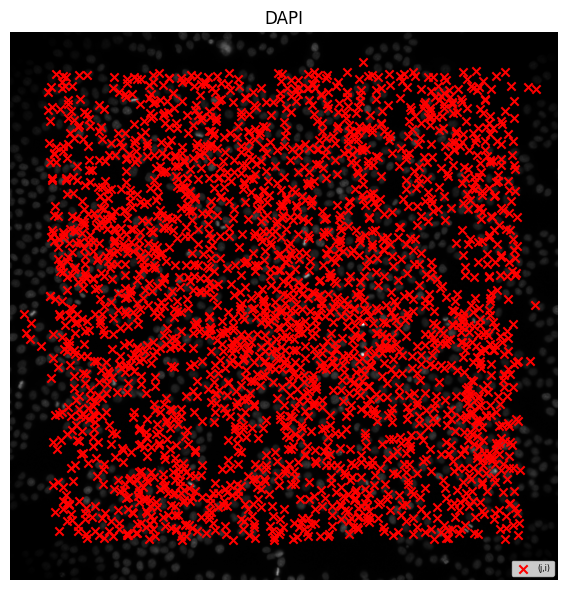

In [9]:
for i, (_, row) in enumerate(s.iterrows()):
    plate = row['plate']
    well = row['well']
    site = row['site']
    
    print(len(just_here))

    # Check if channels are available
    available_channels = get_available_channels(plate, well, site, base_dir=data_dir)

    if available_channels:
        print(f"Found cell with available channels: {available_channels}")
        print(f"Plate: {plate}, Well: {well}, Site: {site}")
        
        cell_bounds = [0,0, 2960, 2960]

        cell_images = extract_cell_from_site(plate, well, site, cell_bounds, pad=0, base_dir=data_dir, screen='screenA')
        print(f"Cell images: {[cell_images.shape for cell_images in cell_images.values()]}")
        # transform row['cell_i'] row['cell_j'] to the image coordinates
        
        cell_images = {'DAPI' : cell_images['DAPI']}

        fig, axes = plt.subplots(1, len(cell_images), figsize=(6, 6))
        
        if len(cell_images) == 1:
            axes = [axes]
        
        c = 1
        for ax, (channel, img) in zip(axes, cell_images.items()):
            ax.imshow(img[:, :, c], cmap='gray')

            # # Try swapping i and j
            # ax.scatter(just_here['nucleus_i'], just_here['nucleus_j'], marker='x', color='purple', label='(i, j)')
            
            # # Raw plotting
            ax.scatter(just_here['nucleus_j'], just_here['nucleus_i'], marker='x', color='red', label='(j,i)')
            
            # Try flipping j
            # ax.scatter(2960 - just_here['nucleus_i'], just_here['nucleus_j'], 
            #            marker='x', color='blue', label='(flipped i, j)')
            
            # # Try flipping i
            # ax.scatter(just_here['nucleus_i'], 2960 - just_here['nucleus_j'], 
            #            marker='x', color='green', label='(i, flipped j)')
            # # Try flipping j
            # ax.scatter(2960 - just_here['nucleus_j'], just_here['nucleus_i'], 
            #            marker='x', label='(flipped j, i)')
            
            # # Try flipping i
            # ax.scatter(just_here['nucleus_j'], 2960 - just_here['nucleus_i'], 
            #            marker='x', color='green', label='(j, flipped i)')
            
            # # Try flipping both
            # ax.scatter(2960 - just_here['nucleus_i'], 2960 - just_here['nucleus_j'], 
            #            marker='x', color='yellow', label='(flipped i, flipped j)')
            
            # ax.scatter(2960 - just_here['nucleus_j'], 2960 - just_here['nucleus_i'], 
            #            marker='x', label='(flipped j, flipped i)')
            
            
            ax.set_title(f"{channel}")
            ax.axis('off')
            ax.legend(fontsize='xx-small', loc='lower right')           
            
    plt.tight_layout()
    plt.show()

2374
Found cell with available channels: ['DAPI-GFP', 'A594', 'AF750']
Plate: 20200202_6W-LaC024A, Well: A1, Site: 63
Channel DAPI-GFP image shape: (4, 2, 2960, 2960)
Channel A594 image shape: (2960, 2960, 4)
Channel AF750 image shape: (2960, 2960, 4)
Cell images: [(2960, 2960, 4), (2960, 2960, 4), (2960, 2960, 4), (2960, 2960, 4)]


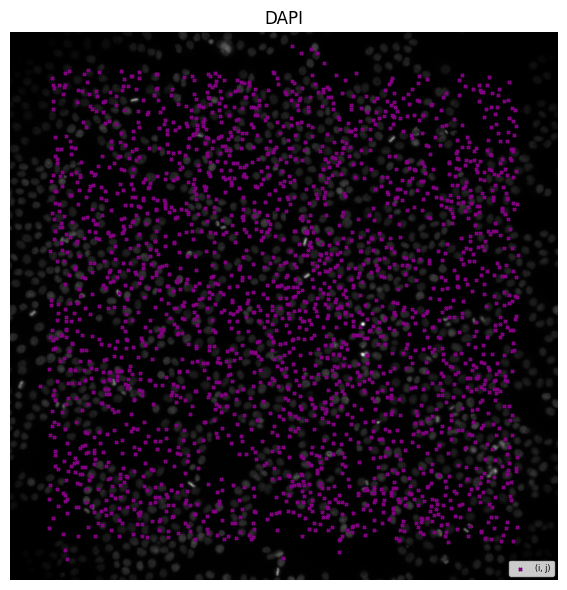

In [15]:
for i, (_, row) in enumerate(s.iterrows()):
    plate = row['plate']
    well = row['well']
    site = row['site']
    
    print(len(just_here))

    # Check if channels are available
    available_channels = get_available_channels(plate, well, site, base_dir=data_dir)

    if available_channels:
        print(f"Found cell with available channels: {available_channels}")
        print(f"Plate: {plate}, Well: {well}, Site: {site}")
        
        cell_bounds = [0,0, 2960, 2960]

        cell_images = extract_cell_from_site(plate, well, site, cell_bounds, pad=0, base_dir=data_dir, screen='screenA')
        print(f"Cell images: {[cell_images.shape for cell_images in cell_images.values()]}")
        # transform row['cell_i'] row['cell_j'] to the image coordinates
        
        cell_images = {'DAPI' : cell_images['DAPI']}

        fig, axes = plt.subplots(1, len(cell_images), figsize=(6, 6))
        
        if len(cell_images) == 1:
            axes = [axes]
        
        c = 1
        for ax, (channel, img) in zip(axes, cell_images.items()):
            ax.imshow(img[:, :, c], cmap='gray')

            # # Try swapping i and j
            ax.scatter(just_here['nucleus_i'], just_here['nucleus_j'], 
                       marker='x', color='purple', label='(i, j)', s=5)
            
            # # Raw plotting
            # ax.scatter(just_here['nucleus_j'], just_here['nucleus_i'], marker='x', color='red', label='(j,i)')
            
            # Try flipping j
            # ax.scatter(2960 - just_here['nucleus_i'], just_here['nucleus_j'], 
            #            marker='x', color='blue', label='(flipped i, j)')
            
            # # Try flipping i
            # ax.scatter(just_here['nucleus_i'], 2960 - just_here['nucleus_j'], 
            #            marker='x', color='green', label='(i, flipped j)')
            # # Try flipping j
            # ax.scatter(2960 - just_here['nucleus_j'], just_here['nucleus_i'], 
            #            marker='x', label='(flipped j, i)')
            
            # # Try flipping i
            # ax.scatter(just_here['nucleus_j'], 2960 - just_here['nucleus_i'], 
            #            marker='x', color='green', label='(j, flipped i)')
            
            # # Try flipping both
            # ax.scatter(2960 - just_here['nucleus_i'], 2960 - just_here['nucleus_j'], 
            #            marker='x', color='yellow', label='(flipped i, flipped j)')
            
            # ax.scatter(2960 - just_here['nucleus_j'], 2960 - just_here['nucleus_i'], 
            #            marker='x', label='(flipped j, flipped i)')
            
            
            ax.set_title(f"{channel}")
            ax.axis('off')
            ax.legend(fontsize='xx-small', loc='lower right')           
            
    plt.tight_layout()
    plt.show()